In [3]:
import torch
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: Load MNIST with PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1] and shape [1, 28, 28]
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Combine train and test datasets
full_data = torch.cat([mnist_dataset.data, mnist_test_dataset.data], dim=0)
full_targets = torch.cat([mnist_dataset.targets, mnist_test_dataset.targets], dim=0)

# Step 2: Normalize and flatten
full_data = full_data.view(-1, 28*28).float() / 255.0  # [70000, 784]
full_targets = full_targets.numpy()

# Step 3: PCA to reduce to 50 dims
pca = PCA(n_components=50)
X_pca = pca.fit_transform(full_data.numpy())
print(f"PCA retained {np.sum(pca.explained_variance_ratio_):.2%} of the variance.")

# Step 4: Split into Train (80%), Val (10%), Test (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_pca, full_targets, test_size=0.2, stratify=full_targets, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42
)

# Final shapes
print(f"Train: {X_train.shape[0]} samples")
print(f"Val: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.76MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 136kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.25MB/s]


PCA retained 82.54% of the variance.
Train: 49778 samples
Val: 6222 samples
Test: 14000 samples


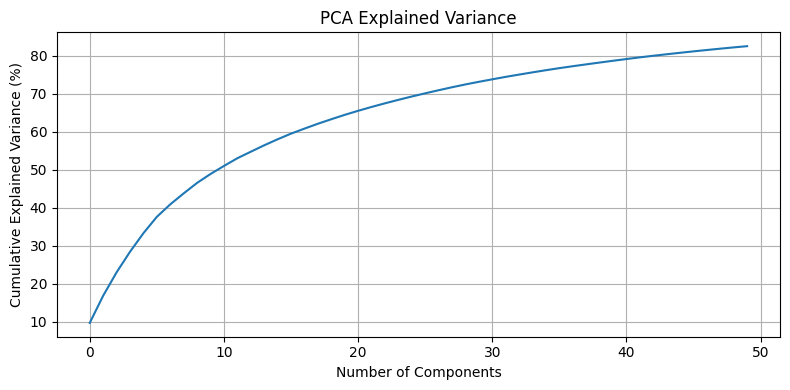

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


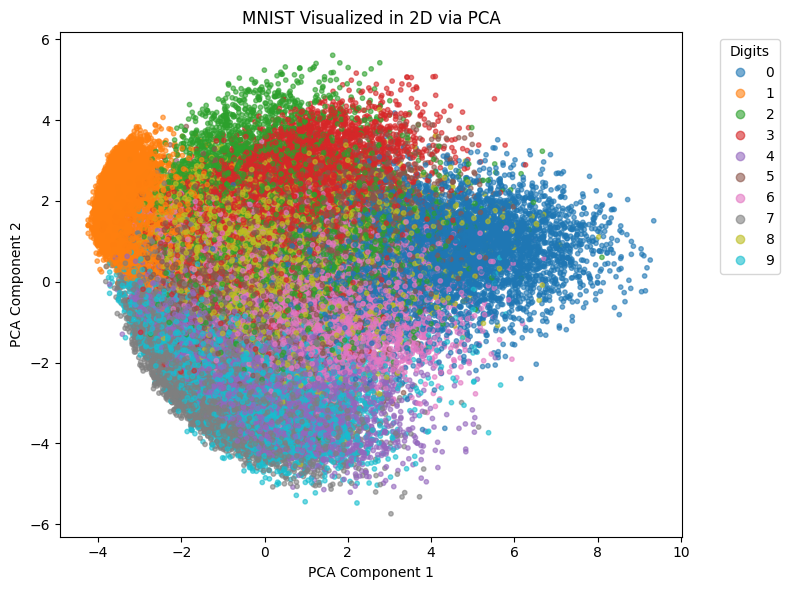

In [9]:
# Use only 2 components for visualization
pca_2d = PCA(n_components=50)
X_2d = pca_2d.fit_transform(full_data.numpy())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=full_targets, cmap='tab10', alpha=0.6, s=10)
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MNIST Visualized in 2D via PCA')
plt.tight_layout()
plt.show()


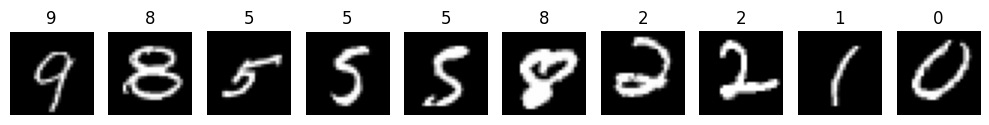

In [10]:
def show_samples(data, labels, n=10):
    plt.figure(figsize=(10, 1.5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        plt.title(f"{labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 10 random digits from original dataset
indices = np.random.choice(len(full_data), 10, replace=False)
show_samples(full_data[indices], full_targets[indices])


GMM Accuracy (after mapping clusters to digits): 0.6456


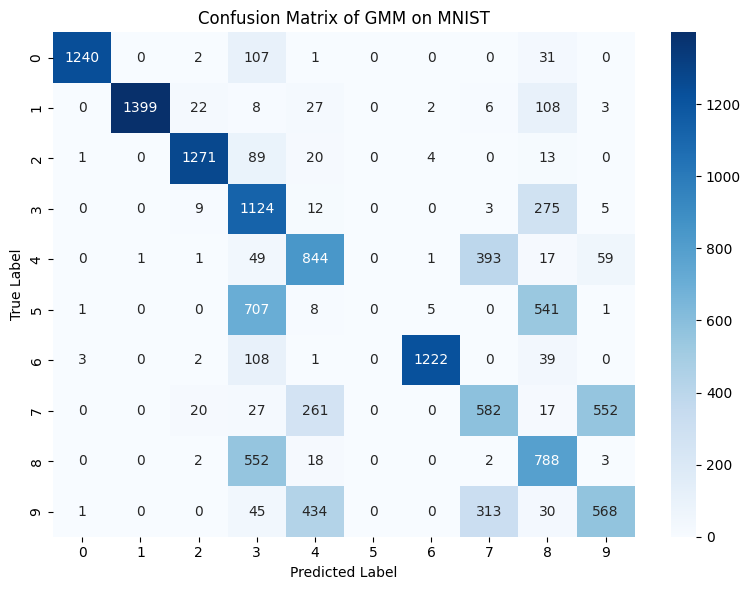

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Fit GMM with 10 components (digits 0–9)
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm.fit(X_train)

# Step 2: Predict cluster assignments on test data
y_pred = gmm.predict(X_test)

# Step 3: Map GMM cluster labels to true digit labels using majority vote
def map_clusters_to_digits(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in range(10):
        mask = (y_pred == i)
        if np.any(mask):
            labels[mask] = mode(y_true[mask])[0]
    return labels

y_pred_mapped = map_clusters_to_digits(y_test, y_pred)

# Step 4: Evaluate accuracy
acc = accuracy_score(y_test, y_pred_mapped)
print(f"GMM Accuracy (after mapping clusters to digits): {acc:.4f}")

# Step 5: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_mapped)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of GMM on MNIST')
plt.tight_layout()
plt.show()


GMM Accuracy with soft-label mapping: 0.8504


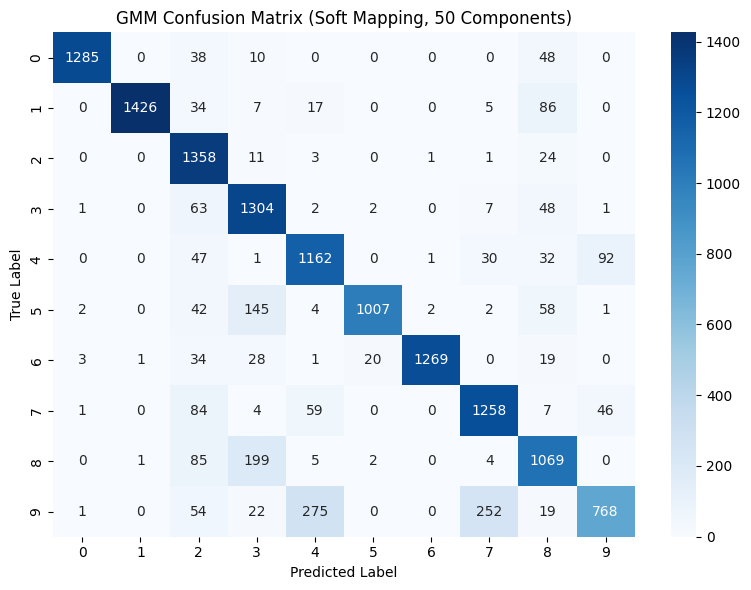

In [21]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Configurable Parameters ---
n_components = 50  # Number of GMM clusters (can be different from num_digits)
num_digits = 10    # Number of unique digit classes (for MNIST it's 10)

# Step 1: Fit GMM
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(X_train)

# Step 2: Predict soft cluster assignments on test data
probs = gmm.predict_proba(X_test)  # shape: (num_samples, n_components)

# Step 3: Learn label distribution for each cluster from training data
train_clusters = gmm.predict(X_train)
label_distribution = np.zeros((n_components, num_digits))

for cluster_id in range(n_components):
    cluster_mask = (train_clusters == cluster_id)
    if np.any(cluster_mask):
        true_labels = y_train[cluster_mask]
        counts = np.bincount(true_labels, minlength=num_digits)
        label_distribution[cluster_id] = counts / counts.sum()

# Step 4: Predict digit labels using soft voting
digit_probs = probs @ label_distribution  # shape: (num_samples, num_digits)
y_pred_soft = np.argmax(digit_probs, axis=1)

# Step 5: Evaluate accuracy
acc_soft = accuracy_score(y_test, y_pred_soft)
print(f"GMM Accuracy with soft-label mapping: {acc_soft:.4f}")

# Step 6: Plot confusion matrix
cm_soft = confusion_matrix(y_test, y_pred_soft)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_digits), yticklabels=range(num_digits))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'GMM Confusion Matrix (Soft Mapping, {n_components} Components)')
plt.tight_layout()
plt.show()
